# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal


# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy
import torch

import numpy as np
import pandas as pd

from astropy.io  import fits
from astropy     import units as u
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from spectral_cube import SpectralCube

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
ct256_checkpoint_path = checkpoint_path / 'c256_1split'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'
bighicat = tanosignal_path / 'bighicat'

saury2014_data_path = data_path / 'saury'
seta_data_path = data_path / 'seta'

print(tano_signal_path)
print(checkpoint_path)
print(ct101_checkpoint_path)
print(cnn101_checkpoint_path)
print('UMA: ', uma_data_path)
print('Saury 2014: ', saury2014_data_path)

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

# Read BIGHICAT

In [ ]:
bighicat_csvfile = bighicat / 'all_unique_LOS_BIGHICAT.csv'
bighicat_df = pd.read_csv(bighicat_csvfile)
print('nrows, ncols: ', bighicat_df.shape)
bighicat_df

In [ ]:
bighicat_fcnm = bighicat_df.f_CNM_LOS.values
bighicat_fcnm.shape

(374,)

In [ ]:
z_df = bighicat_df[~bighicat_df.survey.isin(['MACH', '21-SPONGE', 'Millennium03'])]
z_df = z_df[z_df.ncomps > -1]
print(z_df.shape)
z_gl = z_df.lon.values
z_gb = z_df.lat.values
z_ncnm = z_df.ncomps.values

bighicat_fcnm = z_df.f_CNM_LOS.values

(222, 39)


# SPONGE

In [ ]:
sp_csvfile = bighicat / '21SPONGE_rl_ew.csv'
spdf = pd.read_csv(sp_csvfile)
spdf = spdf.drop([27, 41]) # Drop 3C245B, J1613 (no result)
spdf

In [ ]:
sp21_fcnm    = spdf['fcnm'].values
sp21_sigfcnm = spdf['sigfcnm'].values

sp21_rhi    = spdf['rhi'].values
sp21_sigrhi = spdf['sigrhi'].values

sp21_lat    = np.abs(spdf.lat.values)

sp21_fcnm.shape

(54,)

# MACH

In [ ]:
mach_csvfile = bighicat / 'mach_los_rl_ew.csv'
mdf = pd.read_csv(mach_csvfile)
mdf

In [ ]:
m_fcnm    = mdf['fcnm'].values
m_sigfcnm = mdf['sigfcnm'].values

m_rhi    = mdf['rhi'].values
m_sigrhi = mdf['sigrhi'].values

m_lat = np.abs(mdf.glat.values)

m_fcnm.shape

(44,)

# MS (HT03)

In [ ]:
ms_csvfile = bighicat / 'ms_los_rl_ew.csv'
msdf = pd.read_csv(ms_csvfile)
print(msdf.shape)
msdf

In [ ]:
ms_csvfile = bighicat / 'nhi_lb_79src_HT03.txt'
msdf = pd.read_csv(ms_csvfile)
print('nrows, ncols:', msdf.shape)
msdf

In [ ]:
ms_fcnm    = msdf['fcnm'].values
ms_sigfcnm = msdf['sigfcnm'].values

ms_rhi    = msdf['rhi'].values
ms_sigrhi = msdf['sigrhi'].values

ms_lat = np.abs(msdf.gb.values)

ms_fcnm.shape

(79,)

# GNOMES

In [ ]:
gn_csvfile = bighicat / 'GNOMES.csv'
gndf = pd.read_csv(gn_csvfile)
print('nrows, ncols: ', gndf.shape)
gndf

In [ ]:
gn_fcnm    = gndf['fcnm'].values
gn_sigfcnm = gndf['sigfcnm'].values

gn_rhi    = gndf['rhi'].values
gn_sigrhi = gndf['sigrhi'].values

gn_fcnm.shape

(77,)

# Perseus

In [ ]:
ps_csvfile = bighicat / 'mach_los.csv'
psdf = pd.read_csv(ps_csvfile)
psdf = psdf[psdf['survey'] == 'Perseus']
print('nrows, ncols: ', psdf.shape)
psdf

In [ ]:
ps_fcnm    = psdf['fcnm'].values
ps_sigfcnm = psdf['sigfcnm'].values

ps_rhi    = psdf['rhi'].values
ps_sigrhi = psdf['sigrhi'].values

ps_fcnm.shape

(22,)

# BIGHICAT - combining

In [ ]:
bighicat_fcnm.shape

(222,)

In [ ]:
bighicat_fcnm = np.concatenate((bighicat_fcnm, sp21_fcnm, m_fcnm, ms_fcnm), axis=None)
bighicat_fcnm.shape

(399,)

In [ ]:
bighicat_rhi = np.concatenate((sp21_rhi, m_rhi, ms_rhi, gn_rhi, ps_rhi), axis=None)
bighicat_rhi.shape

(276,)

## Data cube

In [ ]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x n)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = saury2014_data_path / training_data_file_q0
training_data_file_q1 = saury2014_data_path / training_data_file_q1
training_data_file_q2 = saury2014_data_path / training_data_file_q2
training_data_file_q3 = saury2014_data_path / training_data_file_q3

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = saury2014_data_path / rhi_file_q0
rhi_file_q1 = saury2014_data_path / rhi_file_q1
rhi_file_q2 = saury2014_data_path / rhi_file_q2
rhi_file_q3 = saury2014_data_path / rhi_file_q3

# 3a. FCNM maps
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'


fcnm_file_q0 = saury2014_data_path / fcnm_file_q0
fcnm_file_q1 = saury2014_data_path / fcnm_file_q1
fcnm_file_q2 = saury2014_data_path / fcnm_file_q2
fcnm_file_q3 = saury2014_data_path / fcnm_file_q3

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)


seta22_training_data_file = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
tau_data_file_q4          = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
seta22_rhi_file           = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
seta22_fcnm_file          = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'

seta22_training_data_file = seta_data_path / seta22_training_data_file
seta22_rhi_file           = seta_data_path / seta22_rhi_file
seta22_fcnm_file          = seta_data_path / seta22_fcnm_file

In [ ]:
"""# Data"""

print('Saury+ 2014')
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

nchan, ny, nx = cube1.shape
print('nchan, ny, nx:', nchan, ny, nx)
print('2D map shape:', fcnm_data1.shape)
print('2D map shape:', rhi_data1.shape)


# Seta22
print()
print('Seta & Federath 2022')
cube5, header5      = fits.getdata(seta22_training_data_file, header=True)
fcnm_data5, header5 = fits.getdata(seta22_fcnm_file, header=True)
rhi_data5, header5  = fits.getdata(seta22_rhi_file, header=True)

nchan, ny, nx = cube5.shape
print('nchan, ny, nx:',nchan, ny, nx)
print('2D map shape:', fcnm_data5.shape)
print('2D map shape:', rhi_data5.shape)

Saury+ 2014
nchan, ny, nx: 256 512 512
2D map shape: (512, 512)
2D map shape: (512, 512)

Seta & Federath 2022
nchan, ny, nx: 256 512 512
2D map shape: (512, 512)
2D map shape: (512, 512)


In [ ]:
# Velocity range and channel spacing
vmin = -40  # km.s-1
vmax = 40   # km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
v.shape

(256,)

# Histograms of $f_\text{CNM}$ and $R_\text{HI}$

In [ ]:
fcnm_flat_data1 = fcnm_data1.flatten()
fcnm_flat_data2 = fcnm_data2.flatten()
fcnm_flat_data3 = fcnm_data3.flatten()
fcnm_flat_data4 = fcnm_data4.flatten()
fcnm_flat_data5 = fcnm_data5.flatten()

rhi_flat_data1 = rhi_data1.flatten()
rhi_flat_data2 = rhi_data2.flatten()
rhi_flat_data3 = rhi_data3.flatten()
rhi_flat_data4 = rhi_data4.flatten()
rhi_flat_data5 = rhi_data5.flatten()

In [ ]:
bighicat_fcnm = bighicat_fcnm[~np.isnan(bighicat_fcnm)]
bighicat_fcnm.shape

(269,)

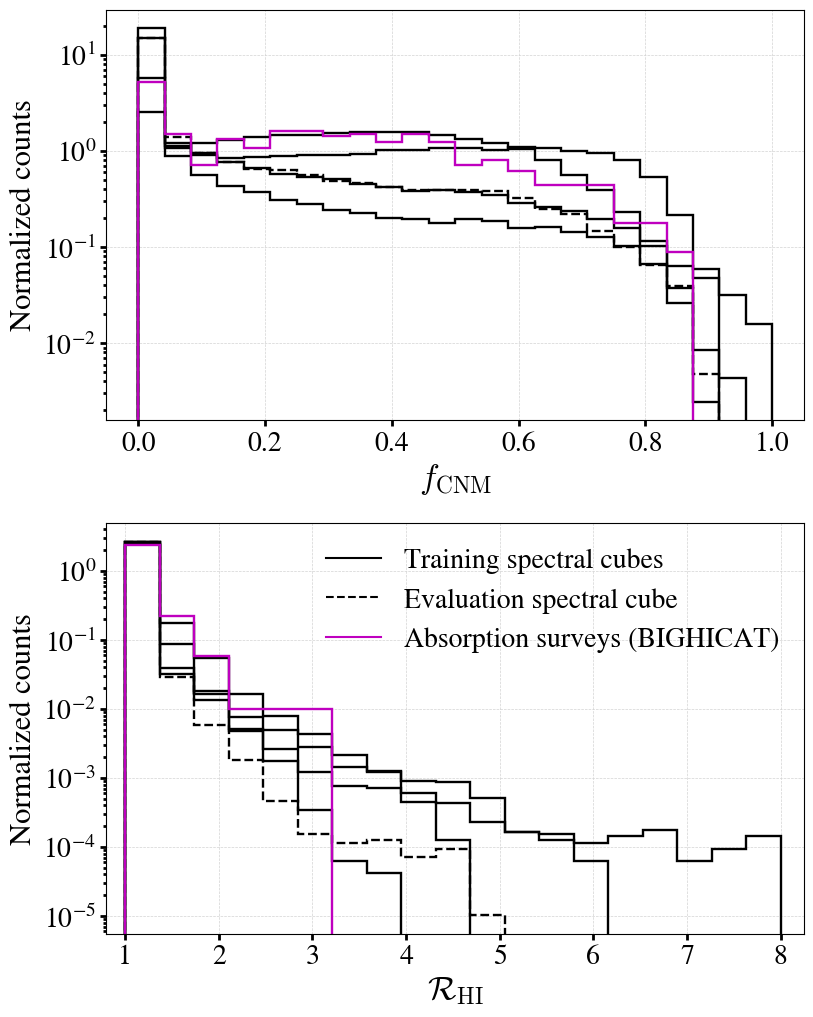

In [ ]:
fig = plt.figure(figsize=(9,12))


# Plot:
ax = fig.add_subplot(211)

lw = 1.7
ls = '-'

nbins = 25
ax.hist(fcnm_flat_data1, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data2, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data4, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(fcnm_flat_data3, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data5, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

plt.hist(bighicat_fcnm, bins=np.linspace(0., 1., nbins),
         density=True, color='m', histtype='step', alpha=1.,
         ls='-', lw=lw, label='')

plt.yscale('log')


# Add axes labels
ax.set_xlabel(r'$f_\mathrm{CNM}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)



ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# Plot:
ax = fig.add_subplot(212)

ls = '-'
nbins = 20

ax.hist(rhi_flat_data1, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data2, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data4, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(rhi_flat_data3, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data5, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')


ax.hist(bighicat_rhi, bins=np.linspace(1., 8., nbins),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=lw,
         label='')


ploti, = ax.plot([], [], 'k-', label='Training spectral cubes')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'k--', label='Evaluation spectral cube')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'm-', label='Absorption surveys (BIGHICAT)')
ploti.set_visible(True)


plt.yscale('log')



# Add axes labels
ax.set_xlabel(r'$\mathcal{R}_\mathrm{HI}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_xlim(0.8, 8.25)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.0, labelcolor='k', fontsize=20)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.25
                    )



plt.show()

In [ ]:
print('BIGHICAT fCNM min, max:', bighicat_fcnm.min(), bighicat_fcnm.max())

BIGHICAT fCNM min, max: 0.0 0.8747913188647747


In [ ]:
print('BIGHICAT RHI min, max:', bighicat_rhi.min(), bighicat_rhi.max())

BIGHICAT RHI min, max: 1.0 3.118108208174369
